In [1]:
#------------------------------------------------------------------ 
# Script to perform a MC simulation of water clusters on the NVT 
# ensemble. The potential energy is predicted by a GNN previously
# trained. 
#------------------------------------------------------------------ 

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Make NumPy printouts easier to read.
np.set_printoptions(precision=4, suppress=True)

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GlobalSumPool, GATConv
import scipy.sparse as sp
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random
import time

from mendeleev import H, O

2023-05-25 13:09:45.255972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 13:09:45.444977: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-25 13:09:46.104778: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-25 13:09:46.104837: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [7]:
# Function to decide if a random movement is accepted with Metropolist test

exponent_guard = 75.0

def metropolis(delta):

    # Input: delta is the negative of argument of exponential

    """ if(delta>exponent_guard): # Too high, reject without evaluation
        accept = False
    elif(delta<0): # downhill, accept without evaluating
        accept = True """
    if(delta<0): # downhill, accept without evaluating
        accept = True
    else: # Metropolis test
        zeta = random.uniform(0,1) # uniform random number in (0,1)
        accept = np.exp(-delta) > zeta

    return accept

In [9]:
# function to translate the center of masses to the origin

m_hy = 1e0    # mass of hydrogen atom
m_ox = 16e0   # mass of oxygen atom
m_water = 2*m_hy + m_ox # mass of water molecule

nmols_max = 500
natoms_max = nmols_max*3
m_at = np.zeros(natoms_max)  # auxiliar vector storing masses of H and O atoms
for iat in range(natoms_max):
    if(iat%3==0):
        m_at[iat] = m_ox
    else:
        m_at[iat] = m_hy

def trans_cm( rpos ):

    # compute center of masses
    r_cm = np.zeros(3)
    m_total = 0e0
    n_atoms = rpos.shape[0]
    #rpos_trans = np.zeros((n_atoms,3))
    n_mols = n_atoms/3
    #m_at = m_at[0:n_atoms]
    #r_cm = r_cm + m_at*rpos[:,]
    for iat in range(n_atoms):
        r_cm[:] = r_cm[:] + m_at[iat]*rpos[iat,:]
    m_total = n_mols * m_water
    r_cm = r_cm / m_total

    # translate center of masses
    #rpos_trans[iat,:] = rpos[iat,:] - r_cm[:]
    rpos_trans = rpos - r_cm

    return rpos_trans

In [15]:
# Generate dataset for different cluster size and temperature

structures_dir = '../structures-SPC/'

# Constants
kb = 3.1668114e-6 # Boltzmann constant in atomic units (Hartree/Kelvin)
ang_to_au = 1e0 / 0.529177e0

nsteps = 1000
dr_max = 0.1            # length of the movement in atomic units (Bohrs)

#for N in [20,32,47,76,100,139,190,237]:
#    for T in range(50,350+50,50): # T between 50 and 350 K
for N in [20]:
    for T in range(50,50+50,50):
        #print(T)

        # Set up
        beta = 1e0 / (kb * T)

        # Read initial geometry 
        file_name = structures_dir+str(N)+'.xyz'

        gfile = open(file_name,'r')
        line = gfile.readline()
        columns = line.split()
        natoms = int(columns[0])
        pos0 = np.zeros((natoms,3))
        line = gfile.readline()

        for i in range(natoms):
            line = gfile.readline()
            columns = line.split()
            pos0[i,0] = float(columns[1])
            pos0[i,1] = float(columns[2])
            pos0[i,2] = float(columns[3])
            #pos0[i,:] = float(columns[1:3])
    
        pos0 = pos0 * ang_to_au

        # Perform MC simulation
        
        # Translate center of mass to the origin

        # Save geometry

#print(pos0/ang_to_au)

In [8]:
# Read equilibrated geometry at the selected cluster size and temperature
# Starting from a equilibrated geometry is crucial for a MC simulation??????????
# SE COMPROBARÁ SI ES CRUCIAL O NO CON OTRAS TEMPERATURAS

structures_dir = "../Structures/"
file_name = structures_dir+"N"+str(N)+"-T"+str(temperature)+".xyz"

gfile = open(file_name,'r')
line = gfile.readline()
columns = line.split()
natoms = int(columns[0])
pos0 = np.zeros((natoms,3))
line = gfile.readline()

for i in range(natoms):
    line = gfile.readline()
    columns = line.split()
    pos0[i,0] = float(columns[1])
    pos0[i,1] = float(columns[2])
    pos0[i,2] = float(columns[3])

ang_to_au = 1e0 / 0.529177e0
pos0 = pos0 * ang_to_au
#print(pos0[0,:])

# save positions into graph0
x0 = graph0.x
a0 = graph0.a
e = graph0.e
y = graph0.y
for i in range(natoms):
    x0[i,1:] = pos0[i,:]
a0 = adjacency(pos0)
inputs = [x0, a0, e]
print( "Predicted: "+str(energy_GNN(inputs)) )
graph0 = dataset_aux[0]


Predicted: -4.416972637176514


In [9]:
# function implementing SPC/F potential

kelvin_to_au = 3.16683e-6
mdyn_to_au = 1e0 / 8.2388584e0
mdyntimesang_to_au = 1e0 / 4.3598149e0
mdynoverang_to_au = 1e0 / 15.5691905e0
kcalmol_to_au = 1e0 / 627.51e0
ang_to_au = 1e0 / 0.529177e0
deg_to_rad = np.pi / 180.0e0
eV = 1e0 / 13.60580e0 / 2e0
Kelvin = eV / 11604.45e0

# potential parameters
      
epsilon = 78.22e0       # kelvins
sigma = 3.165e0         # Angstrom
qh = 0.41e0             # electron charge
qo = -2e0 * qh          # electron charge

# SPC/F
rhow = 2.566e0          # Angstroms^-1. Bug in J. Chem. Phys., Vol 106, No. 6, 1997 !!!
dw = 0.708e0            # mdyn * Angstrom
roh_eq = 1.0e0          # Angstroms
theta_eq = 109.47e0     # º
bc = 2.283e0            # mdyn / Angstrom
cc = -1.469e0           # mdyn / Angstrom
dc = 0.776e0            # mdyn / Angstrom

# convert parameters to atomic units

epsilon = epsilon * Kelvin
sigma = sigma * ang_to_au
rhow = rhow / ang_to_au
dw = dw * mdyntimesang_to_au
roh_eq = roh_eq * ang_to_au
theta_eq = theta_eq * deg_to_rad
bc = bc * mdynoverang_to_au
cc = cc * mdynoverang_to_au
dc = dc * mdynoverang_to_au

alj = 4e0 * epsilon * sigma ** 12e0
blj = 4e0 * epsilon * sigma ** 6e0
rhh_eq = 2e0 * roh_eq * np.sin( theta_eq / 2e0 )
kw = dw*rhow*rhow
kb = bc/2e0
kc = cc
kd = dc

def SPCF( rpos ):

      ustretch = 0e0
      ubend = 0e0
      ulj = 0e0
      ucoulomb = 0e0

      n_atoms = rpos.shape[0]
      n_mols = int(n_atoms/3)

      for imol in range(n_mols):

            iox = 3*imol
            ih1 = iox+1
            ih2 = iox+2

            # intra-molecular energy

            roh1 = rpos[ih1,:] - rpos[iox,:]
            roh2 = rpos[ih2,:] - rpos[iox,:]
            rhh = rpos[ih2,:] - rpos[ih1,:]

            roh1 = np.sqrt(np.dot(roh1,roh1))
            roh2 = np.sqrt(np.dot(roh2,roh2))
            rhh = np.sqrt(np.dot(rhh,rhh))

            # O-H streching

            deq = roh1 - roh_eq
            deq2 = deq*deq
            vw1 = kw * deq2
            deq = roh2 - roh_eq
            deq2 = deq*deq
            vw2 = kw * deq2

            ustretch = ustretch + vw1 + vw2

            # H-O-H bending is composed by three terms: Vb, Vc and Vd terms

            # Vb term: H-H stretching
            deq = rhh - rhh_eq
            deq2 = deq*deq
            vb = kb * deq2

            ustretch = ustretch + vb

            # Vc term

            vc = kc * ( roh1 + roh2 - 2e0*roh_eq ) * ( rhh - rhh_eq )
            dvc_droh = kc * ( rhh - rhh_eq )
            dvc_drhh = kc * ( roh1 + roh2 - 2e0*roh_eq )
         
            ubend = ubend + vc

            # Vd term

            vd = kd * ( roh1 - roh_eq ) * ( roh2 - roh_eq )
            dvd_droh1 = kd * ( roh2 - roh_eq )
            dvd_droh2 = kd * ( roh1 - roh_eq )         
         
            ubend = ubend + vd

            # inter-molecular energy
            for jmol in range(imol+1,n_mols):

                  jox = 3*jmol
                  rij = rpos[jox,:] - rpos[iox,:]

                  rij = np.sqrt(np.dot(rij,rij))
                  rij6 = rij**6e0
                  rij12 = rij**12e0

                  # O-O Lennard-Jones interaction

                  ulj = ulj + ( alj/rij6 - blj ) / rij6

                  # Coulomb interaction between charges k and l of imol and jmol

                  for k in range(3):

                        ik = k+ 3*imol
                        rk = rpos[ik,:]

                        if(k==0):
                              qk = qo
                        else:
                              qk = qh

                        for l in range(3):
                              il = l + 3*jmol
                              rl = rpos[il,:]

                              if(l==0):
                                    ql = qo
                              else:
                                    ql = qh

                              rkl = rl - rk
                              rkl = np.sqrt(np.dot(rkl,rkl))

                              ucoulomb = ucoulomb + qk * ql / rkl

      uinter = ulj + ucoulomb
      uintra = ustretch + ubend
      V_SPCF = uinter + uintra

      return V_SPCF

print(SPCF(pos0))


-4.299444370040935


In [26]:
# MC loop

natoms, nfeatures = x.shape
atoms_list = list(range(natoms))
#natoms_move = int(pmove * natoms)

# averages per block
potential_block = np.zeros(nblocks)

# Initial energy
#graph0 = dataset0[0]
x_old = graph0.x
a_old = graph0.a
e = graph0.e
y_old = graph0.y
inputs = [x_old, a_old, e]
#potential_old = energy_GNN(inputs) # COMENTADO
r_old = x[:,1:4]
potential_old = SPCF(r_old) # AÑADIDO
#print(potential_old)

# Energy histogram
Emin = -4.2e0
Emax = -4.0e0
nbins = 200
dE = (Emax-Emin)/nbins
Ehisto = np.zeros(nbins)

n = 0
nmoves = 0
potential_total = 0
start_time = time.time()

#energy_list_gnn = [] # COMENTADO
energy_list = [] # AÑADIDO

for iblock in range(nblocks):

    nmoves_iblock = 0
    potential_iblock = 0

    for istep in range(nsteps):

        n=n+1
        #if(istep%10==0): print(istep)
        #print(istep)

        """ # multi-particle move (30% of particles)

        atoms_move_list = random.sample(atoms_list, natoms_move)
        
        r_new = r_old.copy()
        #r_new[atoms_move_list,:] = (1+random.uniform(-1,1)*dr_max)*r_old[atoms_move_list,:] 
        #r_new[atoms_move_list,:] = r_old[atoms_move_list,:] + random.uniform(-1,1)*dr_max
        for iat in atoms_move_list:
            r_new[iat,0] = r_old[iat,0] + random.uniform(-1,1)*dr_max
            r_new[iat,1] = r_old[iat,1] + random.uniform(-1,1)*dr_max
            r_new[iat,2] = r_old[iat,2] + random.uniform(-1,1)*dr_max

        #r_new = trans_cm(r_new)
        ############### Chequear que números aleatorios son distintos
        x_new = x_old.copy()
        x_new[atoms_move_list,1:] = r_new[atoms_move_list,:]
        #x_new[atoms_move_list,1:] = (1+random.uniform(-1,1)*dr_max)*x_old[atoms_move_list,1:]
        a_new = adjacency(r_new)
        #a_new = adjacency(x_new[:,1:])
        inputs = [x_new, a_new, e]
        potential_new = energy_GNN(inputs)
        #print(potential_new) """

        # single-atom move
        atom_selected = random.randint(0,natoms-1)   # select number between 0 and natoms-1 (both included)
        ux = random.uniform(0,1)
        uy = random.uniform(0,1)
        uz = random.uniform(0,1)
        r_new = r_old.copy()
        r_new[atom_selected,0] = r_old[atom_selected,0] + (ux-0.5)*dr_max
        r_new[atom_selected,1] = r_old[atom_selected,1] + (uy-0.5)*dr_max
        r_new[atom_selected,2] = r_old[atom_selected,2] + (uz-0.5)*dr_max
        #x_new = x_old.copy() # COMENTADO
        #x_new[atom_selected,1:] = r_new[atom_selected,:] # COMENTADO
        #a_new = adjacency(r_new) # COMENTADO
        #inputs = [x_new, a_new, e] # COMENTADO
        #potential_new = energy_GNN(inputs) # COMENTADO
        potential_new = SPCF(r_new) # AÑADIDO

        #print(str(atom_selected)+"  "+str(potential_old)+"  "+str(potential_new))

        # Accept of reject the movement
        delta = (potential_new - potential_old) * beta
        if( metropolis(delta) ):
            potential_old = potential_new
            potential_markov = potential_new
            r_old = r_new.copy()
            #x_old = x_new.copy() # COMENTADO
            nmoves = nmoves + 1    
            nmoves_iblock = nmoves_iblock + 1    
        else:
            potential_markov = potential_old

        # accumulate properties with new element of the Markov chain
        potential_total = potential_total + potential_markov
        potential_iblock = potential_iblock + potential_markov
        """ iE = int( (potential_markov-Emin)/dE )
        Ehisto[iE] = Ehisto[iE] + 1 """

        if((istep+1)%5==0): energy_list.append(potential_markov) # AÑADIDO      
        #if((istep+1)%5==0): energy_list_gnn.append(potential_markov) # COMENTADO

        """ delta = (potential_new - potential_old) * beta
        if( metropolis(delta) ):
            potential_total = potential_total + potential_new
            potential_iblock = potential_iblock + potential_new
            nmoves = nmoves + 1    
            nmoves_iblock = nmoves_iblock + 1    
            r_old = r_new.copy()
            x_old = x_new.copy()
            potential_old = potential_new
            iE = int((potential_new-Emin)/dE)
            Ehisto[iE] = Ehisto[iE] + 1 """
        #print(accept)

    # accumulate block averages
    #potential_block[iblock] = potential_iblock / nmoves_iblock
    potential_block[iblock] = potential_iblock /nsteps
    print("block "+str(iblock)+": Energy "+str(potential_block[iblock])+", acceptance "+str(nmoves_iblock/nsteps*100)+" %")        

end_time = time.time()

exe_time = end_time-start_time # in seconds

metro_ratio = float(nmoves)/float(n)*100    # should be around 50%
#potential_avrg = potential_total / float(nmoves)
potential_avrg = potential_total / float(nsteps*nblocks)
print("Acceptance ratio: "+str(metro_ratio))
print("Potential average: "+str(potential_avrg))
print("Exe time (seconds): "+str(exe_time))

/home/alfonso/Work/UGR/Calculations/WaterClusters_GNNs/GNNs_WaterClusters_venv/lib/python3.10/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


block 0: Energy -4.418741450309754, acceptance 87.0 %
block 1: Energy -4.423096189498901, acceptance 91.0 %
block 2: Energy -4.424532990455628, acceptance 93.0 %
block 3: Energy -4.426463890075683, acceptance 94.0 %
block 4: Energy -4.4309913396835325, acceptance 92.0 %
block 5: Energy -4.437282829284668, acceptance 90.0 %
block 6: Energy -4.4423362922668455, acceptance 90.0 %
block 7: Energy -4.447652659416199, acceptance 91.0 %
block 8: Energy -4.451690721511841, acceptance 89.0 %
block 9: Energy -4.454193148612976, acceptance 92.0 %
block 10: Energy -4.454148774147034, acceptance 86.0 %
block 11: Energy -4.454803519248962, acceptance 93.0 %
block 12: Energy -4.457724585533142, acceptance 88.0 %
block 13: Energy -4.461105289459229, acceptance 91.0 %
block 14: Energy -4.462638502120972, acceptance 90.0 %
block 15: Energy -4.464632544517517, acceptance 90.0 %
block 16: Energy -4.466397075653076, acceptance 88.0 %
block 17: Energy -4.47045578956604, acceptance 91.0 %
block 18: Energy -4

Text(0, 0.5, 'Energy per molecule (kcal/mol)')

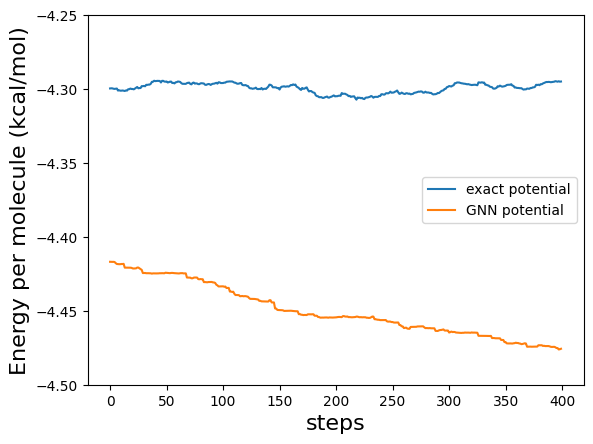

In [42]:
# Plot energy in time
#print(energy_list)

steps = np.arange(len(energy_list))
plt.plot(steps, energy_list, label='exact potential') # AÑADIDO
#plt.plot(steps, energy_list_gnn, label='GNN potential') # COMENTADO
plt.ylim([-4.5,-4.25])
plt.xlabel("steps", fontsize=16)
plt.legend(loc='center right')
plt.ylabel("Energy per molecule (kcal/mol)", fontsize=16)


In [ ]:
""" # Plot energy distribution
print(Ehisto)
Earray = np.zeros(nbins)
for ibin in range(nbins):
    Earray[ibin] = Emin + ibin*dE
plt.plot(Earray,Ehisto)
plt.xlabel('Energy')
plt.ylabel('Distro')
plt.xlim([-4.12,-4.09]) """

In [127]:
# Compute uncertainty with block-averaging
print(potential_block)

########## Repasar implementación error de libro Allen-Tilsdesley
sigma = 0
for iblock in range(nblocks):
    sigma = sigma + (potential_block[iblock]-potential_avrg)**2
sigma = sigma / (nblocks-1)
sigma = np.sqrt(sigma)
print(sigma)
print()

print("Avrg potential (au): "+str(potential_avrg))
print("Sigma: "+str(sigma))
print()
au_to_kcalmol = 627.52
print("Avrg potential/N (kcal/mol): "+str(potential_avrg*au_to_kcalmol/N))
print("Sigma: "+str(sigma*au_to_kcalmol/N))

    

[-4.4376 -4.475  -4.5079 -4.557  -4.5832 -4.6127 -4.637  -4.6619 -4.7027
 -4.7391 -4.7697 -4.8009 -4.8297 -4.854  -4.8791 -4.8904 -4.9051 -4.9364
 -4.9764 -5.0012]
3.3684146040055425

Avrg potential (au): -8.016666888787258
Sigma: 3.3684146040055425

Avrg potential/N (kcal/mol): -21.226239687982194
Sigma: 8.91876595909518
